# LightGBM Model

LightGBM = gradient boosted decision trees, optimized for speed and large data.

Key ideas:
- Trees are built sequentially, each one fixes previous errors
- Focuses on hard-to-predict samples (important with rare claims)
- Uses histogram-based splits → very fast
- Handles missing values (NaN) natively

| Random Forest     | LightGBM                   |
| ----------------- | -------------------------- |
| Trees independent | Trees sequential           |
| Reduces variance  | Reduces bias + variance    |
| Strong baseline   | Usually higher accuracy    |
| Limited ceiling   | Higher performance ceiling |

RF is a strong classical baseline, LightGBM tests whether boosting meaningfully improves risk ranking.

### 1 — Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation


### 2 — Load Data

IMPORTANT: for LightGBM we should convert -1 to NaN.

In [2]:
train = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

X = train.drop(columns=["id", "target"])
y = train["target"]

X = X.replace(-1, np.nan)

X_test = test_df.drop(columns=["id"])



### 3 — Train / Validation Split

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### 4 — LightGBM Dataset Objects

- Converts X/y into an internal format LightGBM can read very efficiently.
- Keeps metadata (categorical features, missing values, etc.).
- Makes training faster and reduces memory usage.

In [4]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)


### 5 — Baseline LightGBM Model

In [5]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(50)]
)



[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 30 rounds
[50]	valid_0's auc: 0.635001	valid_0's binary_logloss: 0.152362
[100]	valid_0's auc: 0.639629	valid_0's binary_logloss: 0.151945
[150]	valid_0's auc: 0.639706	valid_0's binary_logloss: 0.151916
Early stopping, best iteration is:
[121]	valid_0's auc: 0.640458	valid_0's binary_logloss: 0.151905


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


- early_stopping(stopping_rounds=30) → stops training if validation ROC-AUC does not improve for 30 iterations

- log_evaluation(50) → prints evaluation metric every 50 rounds

- **ROC-AUC ≈ 0.640458 → Gini ≈ 0.280916**

Interpretation:
- Confirms class imbalance (~3.64% positive). Important because boosting focuses on rare events (here, insurance claims).
- LightGBM initializes the prediction logit based on overall probability of positive class. -3.274764 corresponds to logit of 0.0364 (~3.6%). A logit is just the log-odds of a probability (logit = ln(p / (1 - p))). LightGBM uses logit space internally because boosting is easier with real-valued numbers than probabilities.
- Early stopping triggered after 30 rounds without improvement. The best iteration was 121 rounds.
- Validation ROC-AUC ≈ 0.6405 → performance metric (better than RF ≈0.632).
- Binary logloss ≈ 0.1519 → measure of prediction error (lower is better).

In [6]:
import matplotlib.pyplot as plt

# feature importances from sklearn API model
importances = pd.Series(lgbm.feature_importances_, index=X.columns)

# top 20
top20 = importances.sort_values(ascending=False).head(20)
top20



ps_car_13        288
ps_reg_03        270
ps_ind_03        238
ps_car_14        208
ps_ind_15        178
ps_reg_02        136
ps_ind_01        133
ps_reg_01        121
ps_ind_05_cat    117
ps_car_01_cat    116
ps_car_15         96
ps_car_09_cat     94
ps_ind_02_cat     84
ps_ind_17_bin     83
ps_calc_14        80
ps_car_11_cat     80
ps_calc_10        75
ps_car_12         72
ps_calc_01        71
ps_car_06_cat     71
dtype: int32

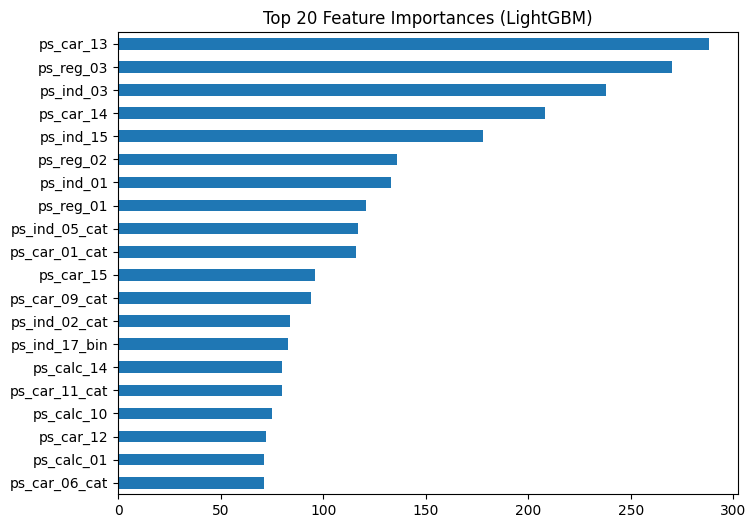

In [7]:
# plot
top20.sort_values().plot(kind="barh", figsize=(8,6), title="Top 20 Feature Importances (LightGBM)")
plt.show()

In [8]:
importances_gain = pd.Series(
    lgbm.booster_.feature_importance(importance_type="gain"),
    index=X.columns
)

importances_gain_norm = importances_gain / importances_gain.sum()

top20_gain = importances_gain_norm.sort_values(ascending=False).head(20)
top20_gain


ps_car_13        0.162781
ps_ind_05_cat    0.082517
ps_reg_03        0.074769
ps_ind_03        0.057040
ps_ind_17_bin    0.050851
ps_ind_15        0.044114
ps_reg_02        0.037366
ps_car_14        0.036839
ps_reg_01        0.030632
ps_ind_06_bin    0.026948
ps_car_01_cat    0.025457
ps_ind_01        0.024815
ps_car_07_cat    0.023597
ps_car_03_cat    0.019248
ps_car_09_cat    0.019170
ps_ind_02_cat    0.017925
ps_car_15        0.017580
ps_car_11_cat    0.014070
ps_calc_14       0.012891
ps_calc_10       0.012882
dtype: float64

<Axes: title={'center': 'Top 20 Feature Importance (Gain, Normalized)'}>

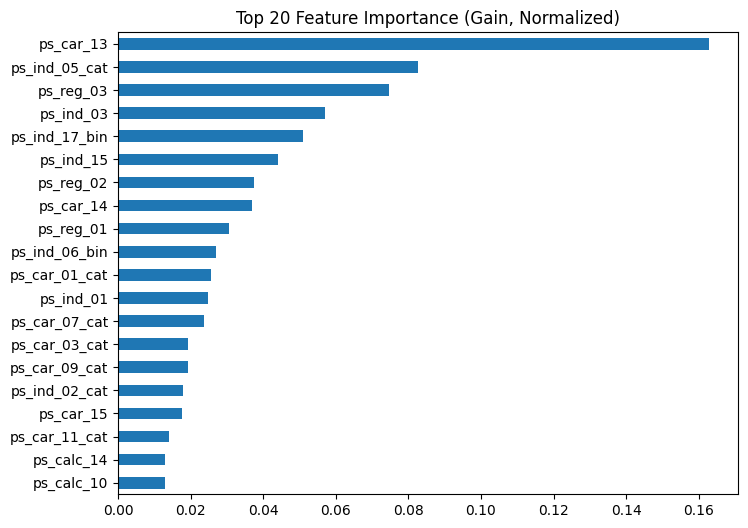

In [9]:
top20_gain.sort_values().plot(kind="barh", figsize=(8,6), title="Top 20 Feature Importance (Gain, Normalized)")


| Rank | Random Forest | LightGBM      |
| ---- | ------------- | ------------- |
| 1    | ps_car_13     | ps_car_13     |
| 2    | ps_reg_03     | ps_reg_03     |
| 3    | ps_ind_05_cat | ps_ind_03     |
| 4    | ps_ind_03     | ps_car_14     |
| 5    | ps_reg_02     | ps_ind_15     |
| 6    | ps_ind_17_bin | ps_reg_02     |
| 7    | ps_car_14     | ps_ind_01     |
| 8    | ps_car_12     | ps_reg_01     |
| 9    | ps_ind_15     | ps_ind_05_cat |
| 10   | ps_car_07_cat | ps_car_01_cat |
| 11   | ps_car_04_cat | ps_car_15     |
| 12   | ps_car_15     | ps_car_09_cat |
| 13   | ps_car_11_cat | ps_ind_02_cat |
| 14   | ps_car_01_cat | ps_ind_17_bin |
| 15   | ps_reg_01     | ps_calc_14    |
| 16   | ps_ind_01     | ps_car_11_cat |
| 17   | ps_car_03_cat | ps_calc_10    |
| 18   | ps_car_06_cat | ps_car_12     |
| 19   | ps_calc_14    | ps_calc_01    |
| 20   | ps_calc_10    | ps_car_06_cat |


Observations:

Top features are almost identical:
- **ps_car_13 and ps_reg_03 are #1 and #2 in both models**
- ps_ind_03, ps_car_14, ps_ind_15, ps_reg_02 all appear in top 6
- Shows that both RF and LightGBM agree on the strongest signals
- Minor differences

RF has ps_ind_05_cat slightly higher than LightGBM:
- LightGBM gives more weight to ps_ind_01 and ps_reg_01
- Some of the “calc” features appear slightly higher in LightGBM (ps_calc_14, ps_calc_10)
- Differences are small — these reflect how boosting vs bagging assigns importance

General pattern:
- Car features dominate (ps_car_*) → vehicle info is most predictive
- Regional / individual features matter (ps_reg_*, ps_ind_*) → location and driver info are also important
- Calculation features (ps_calc_*) have smaller but nonzero importance

Both Random Forest and LightGBM agree that the most important predictors of whether a driver will file a claim are primarily related to vehicle characteristics (ps_car_13, ps_car_14), followed by regional and driver indicators (ps_reg_03, ps_ind_03).
LightGBM also gives slightly more weight to certain individual and calculation features, reflecting its ability to pick up subtle patterns across many weak predictors. Overall, the feature importance is consistent across tree-based models, increasing confidence in these predictors for underwriting risk decisions.

### 6 - Cross-validation test


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    lgbm = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    lgbm.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
             eval_metric='auc', callbacks=[early_stopping(stopping_rounds=30)])
    
    val_pred = lgbm.predict_proba(X_val_fold)[:,1]
    roc = roc_auc_score(y_val_fold, val_pred)
    roc_scores.append(roc)

print(f"5-fold CV ROC-AUC: {np.mean(roc_scores):.4f} ± {np.std(roc_scores):.4f}")


[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.643299	valid_0's binary_logloss: 0.15177
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `forc

### 7 — Baseline LightGBM + dropping engineered features

_calc features appear lower in feature importance → might be noise

In [11]:
# Identify calc features
calc_features = [col for col in X_train.columns if col.startswith('ps_calc')]

# Drop from TRAIN and VAL
X_train_no_calc = X_train.drop(columns=calc_features)
X_val_no_calc = X_val.drop(columns=calc_features)

# Train model
lgbm_no_calc = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_no_calc.fit(
    X_train_no_calc, y_train,
    eval_set=[(X_val_no_calc, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=30)]
)


# ROC-AUC
val_pred = lgbm_no_calc.predict_proba(X_val_no_calc)[:,1]
roc = roc_auc_score(y_val, val_pred)

gini = 2 * roc - 1
print(f"ROC={roc}, GINI={gini}")



[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[137]	valid_0's auc: 0.639863	valid_0's binary_logloss: 0.151877
ROC=0.6398631519987388, GINI=0.27972630399747755


- ROC-AUC ≈ 0.63986 (vs baseline ≈ 0.6404)
- _calc features, while weak individually, still add small signal together
- Boosting is good at exploiting many weak predictors

### 8 — Baseline LightGBM + One-hot encode categorical variables

In [12]:
cat_features = [col for col in X_train.columns if col.endswith("_cat")]

X_train_ohe = pd.get_dummies(X_train, columns=cat_features)
X_val_ohe = pd.get_dummies(X_val, columns=cat_features)


# Align columns
X_val_ohe = X_val_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(X_train_ohe.shape, y_train.shape)
print(X_val_ohe.shape, y_val.shape)

# train
lgbm_ohe = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_ohe.fit(
    X_train_ohe, y_train,
    eval_set=[(X_val_ohe, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=30)]
)

# ROC-AUC
val_pred_ohe = lgbm_ohe.predict_proba(X_val_ohe)[:,1]

roc = roc_auc_score(y_val, val_pred_ohe)

gini = 2 * roc - 1
print(f"ROC={roc}, GINI={gini}")



(476169, 218) (476169,)
(119043, 218) (119043,)
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.639671	valid_0's binary_logloss: 0.151951
ROC=0.6396707321197503, GINI=0.2793414642395007


LightGBM is already very good with categorical-like integer features because:
- It finds optimal split thresholds on integer values
- Many categorical features in this dataset are ordinal-encoded but low-cardinality
- Tree models don’t assume numeric distance the way linear models do

When you apply one-hot encoding:
- You massively increase dimensionality
- You lose natural grouping between categories
- Trees now must learn many binary splits instead of compact thresholds

| Experiment          | Change                                    | ROC-AUC    | Gini       | Decision |
| ------------------- | ----------------------------------------- | ---------- | ---------- | -------- |
| Baseline LightGBM   | All features, native categorical handling | **0.6405** | **0.2810** | Selected |
| No `_calc` features | Dropped engineered features               | 0.6399     | 0.2797     | Rejected |
| OHE categorical     | One-hot encoded categorical variables     | 0.6397     | 0.2793     | Rejected |


While feature engineering and alternative encoding strategies were tested, neither improved model discrimination, and the baseline LightGBM model achieved the highest Gini and ROC-AUC with the simplest pipeline.

### 9 - Predict Probabilities & Submission File for Kaggle

In [13]:
y_proba = lgbm.predict_proba(X_test)[:, 1]

In [14]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": y_proba
})

submission.to_csv("submission.csv", index=False)


In [15]:
print(X_train.shape)
print(X_test.shape)


(476169, 57)
(892816, 57)


### 10 - SHAP value importance

In [16]:
import shap

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val)


/Users/nmunoz/aipm-1711/ds-safe-driver-prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nmunoz/aipm-1711/ds-safe-driver-prediction/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


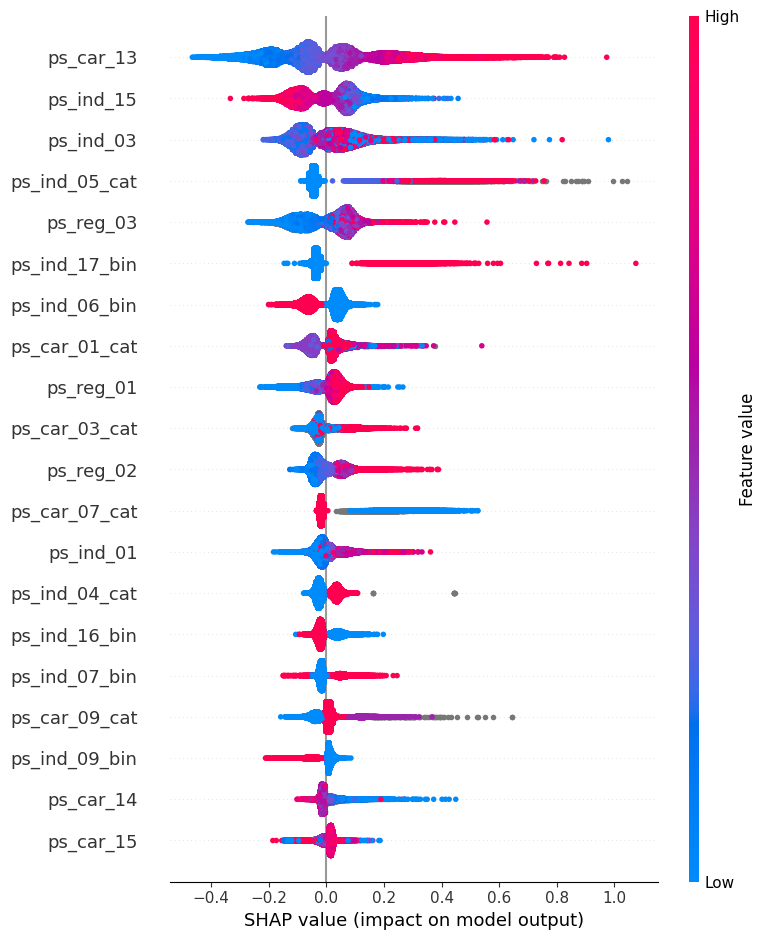

In [17]:
shap.summary_plot(shap_values, X_val)
